In [65]:
import os
os.environ["PROJ_LIB"] = "C:/Anaconda/Library/share";
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from mpl_toolkits.basemap import Basemap

In [2]:
s_shorttem = pd.read_csv('data/LAMBDA/ecmwf_for_LAMBDA_super_shortterm.tsv', sep='\t').drop(['ecmwf', 'ecmwf_2d_gentime', 'ecmwf_2d_time'], axis=1)

In [3]:
s_shorttem.shape

(5128612, 5)

In [4]:
s_shorttem.head(5)

,time,fact_latitude,fact_longitude,fact_station_id,fact_temperature
0,1577862000,36.210701,-115.194000,20589,4.0
1,1577862000,38.426601,-113.012001,19551,-7.0
2,1577862000,34.120300,-119.121002,19738,14.0
3,1577862000,47.793301,13.004300,22107,-5.0
4,1577862000,66.017000,8.083000,70298,7.0


In [5]:
coords = s_shorttem['fact_latitude'].apply(str) + ' ' + s_shorttem['fact_longitude'].apply(str)
coords = np.unique(coords.values)
tmp = []
for x in coords:
    la, lo = x.split()
    tmp.append((float(la), float(lo)))
coords = np.array(tmp)

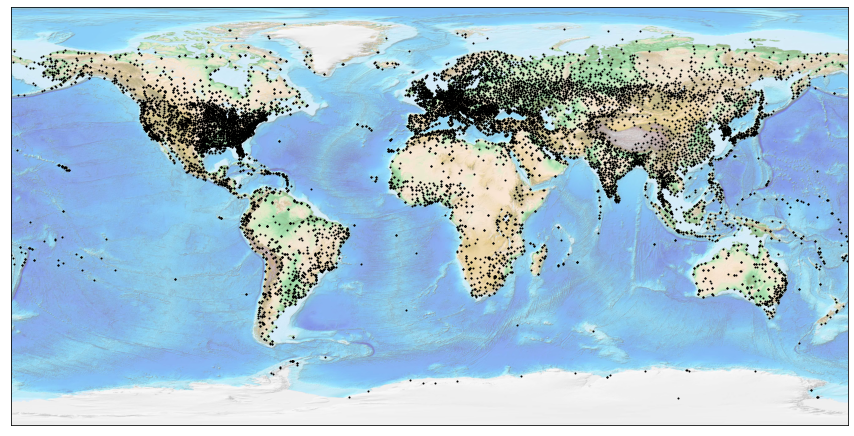

In [6]:
fig = plt.figure(figsize=(15, 15))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180)
m.etopo(scale=1, alpha=0.5)

for (x, y) in coords:
    plt.plot(y, x, 'ok', markersize=1)

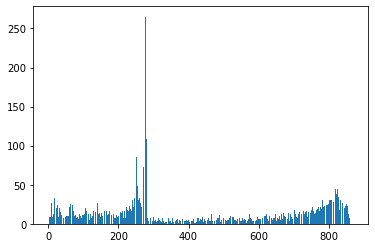

In [7]:
plt.hist(s_shorttem.groupby('fact_station_id').size(), bins=1000)
plt.show()

In [8]:
print(datetime.fromtimestamp(s_shorttem.time.min()))
print(datetime.fromtimestamp(s_shorttem.time.max()))

2020-01-01 10:00:00
2020-12-16 00:00:00


In [10]:
def draw_sample(data):
    fig = plt.figure(figsize=(15, 15))
    m = Basemap(projection='cyl', resolution='f',
                llcrnrlat=data.fact_latitude.min() - 1, urcrnrlat=data.fact_latitude.max() + 1,
                llcrnrlon=data.fact_longitude.min() - 1, urcrnrlon=data.fact_longitude.max() + 1)
    m.shadedrelief()
    coords = data['fact_latitude'].apply(str) + ' ' + data['fact_longitude'].apply(str)
    coords = np.unique(coords.values)
    tmp = []
    for x in coords:
        la, lo = x.split()
        tmp.append((float(la), float(lo)))
    coords = np.array(tmp)
    
    for (x, y) in coords:
        plt.plot(y, x, 'ok', markersize=3)

In [11]:
def generate_window(data, window_center, window_size):
    L = window_center[0] - window_size / 2
    U = window_center[1] - window_size / 2
    
    
    return data[(data.fact_latitude > U) & (data.fact_latitude < U + window_size) &
                (data.fact_longitude > L) & (data.fact_longitude < L + window_size)]

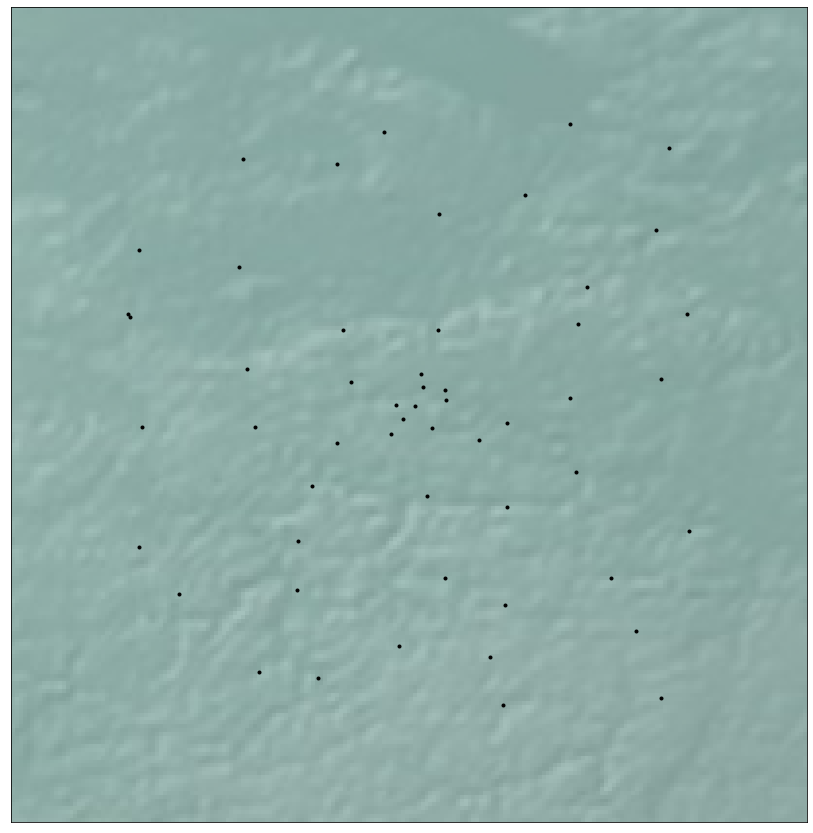

In [12]:
m = generate_window(s_shorttem, [37.39, 55.64], 5).drop_duplicates()
draw_sample(m)

In [13]:
display(m)

,time,fact_latitude,fact_longitude,fact_station_id,fact_temperature
347,1577862000,54.549999,36.366669,34182,0.0
1995,1577865600,55.553299,38.150002,34190,0.0
2073,1577865600,55.972599,37.414600,34193,-2.0
3543,1577865600,55.591499,37.261501,34214,-2.0
4381,1577865600,55.408798,37.906300,34191,-1.0
...,...,...,...,...,...
5127765,1608066000,57.333333,37.566667,49461,-5.0
5128076,1608066000,53.783333,39.250000,49526,-5.0
5128077,1608066000,55.016667,36.483333,49496,-4.0
5128185,1608066000,55.591499,37.261501,34214,-4.0


In [22]:
def sample_from_window(w, col):
    s = pd.DataFrame(columns = np.sort(w.fact_station_id.unique()))
    for t in np.sort(w.time.unique()):
        s.loc[t] = dict(w[w.time == t].set_index('fact_station_id')[col])
    return s

In [24]:
s = sample_from_window(m, 'fact_temperature')
display(s)

,34182,34190,34191,34193,34198,34214,49419,49449,49450,49452,...,66364,66380,66384,66386,66401,66403,66411,66412,66413,66423
1577862000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577865600,-1.0,0.0,-1.0,-2.0,-1.0,-2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577869200,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-4.0,-5.0,-6.0,-5.0,...,-3.0,-1.0,-2.0,-2.0,-1.0,0.0,1.0,1.0,0.0,1.0
1577872800,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577876400,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608051600,-3.0,-5.0,-4.0,-4.0,-4.0,-4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608055200,-3.0,-5.0,-4.0,-4.0,-4.0,-4.0,-3.0,-4.0,-5.0,-5.0,...,-6.0,-2.0,-4.0,-4.0,-2.0,-3.0,-2.0,-3.0,-4.0,-5.0
1608058800,-3.0,-5.0,-4.0,-4.0,-4.0,-4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1608062400,-3.0,-5.0,-4.0,-5.0,-6.0,-4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
def fill_nan(df):
    df.iloc[0] = df.fillna(method = 'bfill').iloc[0]
    df.iloc[-1] = df.fillna(method = 'ffill').iloc[-1]
    df.interpolate(method='linear', inplace = True)

In [26]:
fill_nan(s)
display(s)

,34182,34190,34191,34193,34198,34214,49419,49449,49450,49452,...,66364,66380,66384,66386,66401,66403,66411,66412,66413,66423
1577862000,0.0,0.0,-1.0,-2.0,-1.0,-2.0,-4.000000,-5.000000,-6.000000,-5.000000,...,-3.0,-1.000000,-2.000000,-2.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
1577865600,-1.0,0.0,-1.0,-2.0,-1.0,-2.0,-4.000000,-5.000000,-6.000000,-5.000000,...,-3.0,-1.000000,-2.000000,-2.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
1577869200,-2.0,-1.0,-2.0,-2.0,-2.0,-2.0,-4.000000,-5.000000,-6.000000,-5.000000,...,-3.0,-1.000000,-2.000000,-2.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
1577872800,-1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.666667,-4.333333,-5.333333,-4.666667,...,-3.0,-1.333333,-2.333333,-2.333333,-1.666667,-0.666667,0.333333,0.333333,-0.333333,0.666667
1577876400,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-3.333333,-3.666667,-4.666667,-4.333333,...,-3.0,-1.666667,-2.666667,-2.666667,-2.333333,-1.333333,-0.333333,-0.333333,-0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608051600,-3.0,-5.0,-4.0,-4.0,-4.0,-4.0,-3.000000,-4.000000,-5.000000,-5.000000,...,-6.0,-2.333333,-4.000000,-4.000000,-2.333333,-3.000000,-2.000000,-3.333333,-4.000000,-5.000000
1608055200,-3.0,-5.0,-4.0,-4.0,-4.0,-4.0,-3.000000,-4.000000,-5.000000,-5.000000,...,-6.0,-2.000000,-4.000000,-4.000000,-2.000000,-3.000000,-2.000000,-3.000000,-4.000000,-5.000000
1608058800,-3.0,-5.0,-4.0,-4.0,-4.0,-4.0,-3.333333,-4.000000,-5.000000,-4.666667,...,-6.0,-2.000000,-4.000000,-4.000000,-2.000000,-3.000000,-2.000000,-3.000000,-4.000000,-5.000000
1608062400,-3.0,-5.0,-4.0,-5.0,-6.0,-4.0,-3.666667,-4.000000,-5.000000,-4.333333,...,-6.0,-2.000000,-4.000000,-4.000000,-2.000000,-3.000000,-2.000000,-3.000000,-4.000000,-5.000000


In [29]:
lat = sample_from_window(m, 'fact_latitude')
fill_nan(lat)
display(lat)

,34182,34190,34191,34193,34198,34214,49419,49449,49450,49452,...,66364,66380,66384,66386,66401,66403,66411,66412,66413,66423
1577862000,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1577865600,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1577869200,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1577872800,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1577876400,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608051600,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1608055200,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1608058800,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21
1608062400,54.549999,55.553299,55.408798,55.972599,55.5117,55.591499,56.483333,57.8,58.033333,58.1,...,55.93,55.75,55.46,55.86,54.5,54.13,53.43,53.65,53.56,53.21


In [30]:
lon = sample_from_window(m, 'fact_longitude')
fill_nan(lon)
display(lon)

,34182,34190,34191,34193,34198,34214,49419,49449,49450,49452,...,66364,66380,66384,66386,66401,66403,66411,66412,66413,66423
1577862000,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1577865600,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1577869200,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1577872800,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1577876400,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608051600,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1608055200,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1608058800,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46
1608062400,36.366669,38.150002,37.9063,37.4146,37.507198,37.261501,34.916667,35.9,37.1,38.683333,...,39.46,37.63,37.16,37.43,35.01,36.36,36.03,37.23,38.0,39.46


In [31]:
s = []
for c in ['fact_temperature', 'fact_latitude', 'fact_longitude']:
    tmp = sample_from_window(m, c)
    fill_nan(tmp)
    s.append(tmp)

In [94]:
def dataset_from_samples(s, time_window_train, time_window_test, time_step):
    t = torch.tensor(np.array([s[i].values for i in range(len(s))]))
    t = t.permute(1,2,0)
    X = []
    Y = []
    
    for i in range((t.shape[0] - (time_window_train + time_window_test)) // time_step):
        start = i*time_step
        x = t[start:start+time_window_train]
        y = t[start+time_window_train:start+time_window_train+time_window_test]
        X.append(x)
        Y.append(y)
    X = torch.stack(X, 0).permute(0,2,1,3)
    Y = torch.stack(Y, 0).permute(0,2,1,3)
    
    return TensorDataset(X, Y)

In [95]:
d = dataset_from_samples(s, 24, 8, 1)
print(len(d))
print(d[0][0].shape)
print(d[0][1].shape)

312
torch.Size([54, 24, 3])
torch.Size([54, 8, 3])


In [96]:
dataloader = torch.utils.data.DataLoader(d, batch_size=32, drop_last=True, shuffle=True)

In [97]:
for x, y in dataloader:
    print(x.shape, y.shape)

torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])
torch.Size([32, 54, 24, 3]) torch.Size([32, 54, 8, 3])


![HiSTGNN](https://www.researchgate.net/publication/358144186/figure/fig2/AS:1116887320674305@1643298096679/The-framework-of-HiSTGNN-The-start-conv-is-a-111-standard-convolution-to-project-the.png)

In [ ]:
class AGL(nn.Module):
    def __init(self, inp_size, emb_size, alpha):
        #self.conv = 1x1x1 conv?
        self.emb1 = nn.Embedding(inp_size, emb_size)
        self.emb2 = nn.Embedding(inp_size, emb_size)
        self.lin1 = nn.Linear(emb_size,emb_size)
        self.lin2 = nn.Linear(emb_size,emb_size)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.alpha = alpha
    def forward(self, x):
        #x = self.conv(x) ?
        E1 = self.emb1(x)
        E2 = self.emb2(x)
        M1 = self.tanh(self.alpha * self.lin1(E1))
        M2 = self.tanh(self.alpha * self.lin2(E2))
        M = torch.mm(M1, M2.transpose(1,0)) - torch.mm(M2, M1.transpose(1,0))
        A = self.relu(torch.tanh(self.alpha*M))
        return A

In [ ]:
class GTC(nn.Module):
    def __init(self, ):
        
    def forward(self, x):
        
class SGC(nn.Module):
    def __init(self, ):
        
    def forward(self, x):
        
class STL(nn.Module):
    def __init(self, ):
        self.gtc = GTC()
        self.ln_1 = nn.LayerNorm([])
        self.sgc = SGC()
        self.ln_2 = nn.LayerNorm([])
    def forward(self, x):
        x = self.gtc(x)
        x = self.ln_1(x)
        x = self.sgc(x)
        x = self.ln_2(x)
        return x

In [ ]:
class IFL(nn.Module):
    def __init(self, ):
        
    def forward(self, x):
        
class IDL(nn.Module):
    def __init(self, ):
        
    def forward(self, x):

In [ ]:
class GNN_Layer(nn.Module):
    def __init(self, ):
        
    def forward(self, x):

class GNN(nn.Module):
    def __init(self, ):
        
    def forward(self, x):

In [ ]:
import wandb

def calc_loss(target, y):
    pass

def train(loader, model, device, optim):
    losses = []
    for x, target in tqdm(loader, leave=False):
        x = x.to(device)
        target = target.to(device)
        
        y = model(x)
        
        logdet = logdet.mean()
        loss = calc_loss(target, y)
        
        model.zero_grad()
        loss.backward()
        optim.step()
        
        losses.append(loss)
        
        wandb.log({'loss': loss})
        
    return sum(losses) / len(losses)      

def full_train_models(device, train_loader):
    gnn = GNN(_______)
    gnn = gnn.to(device)
    lr = 1e-4
    optim = torch.optim.Adam(gnn.parameters(), lr=lr)
    n_epochs = 100
    ch = 10
    for e in trange(n_epochs): 
        loss = train(train_loader, gnn, device, optim)
        if (e + 1) % ch == 0:
            torch.save(gnn.state_dict(), "checkpoint-{:d}e.pt".format(e + 1))
        print(f'Epoch: {e+1}/{n_epochs}')
        print(f'Loss: {loss:.4f}')
    return gnn
        

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
dataloader = torch.utils.data.DataLoader(d, batch_size=32, drop_last=True, shuffle=True)
wandb.init(project="HiSTGNN")
gnn = full_train_models(device, dataloader)